In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv, find_dotenv
from pathlib import Path

from src.data.rgbd import load_rgbd

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
project_dir = Path(dotenv_path).parent

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

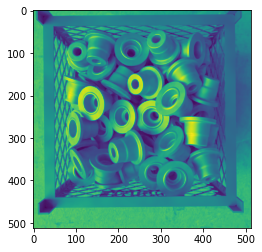

In [5]:
raw_data_dir = project_dir/'data/raw/render_results'

img_fpath = np.random.choice(list(raw_data_dir.glob('simulacao*/*.png')))

rgbd_img = load_rgbd(img_fpath, depth_scale=1)

color = np.asarray(rgbd_img.color)
plt.imshow(color)

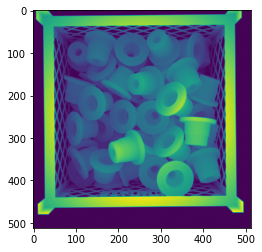

In [6]:
depth = np.asarray(rgbd_img.depth)
plt.imshow(depth)

# Edge detection using Canny

OpenCV approach:

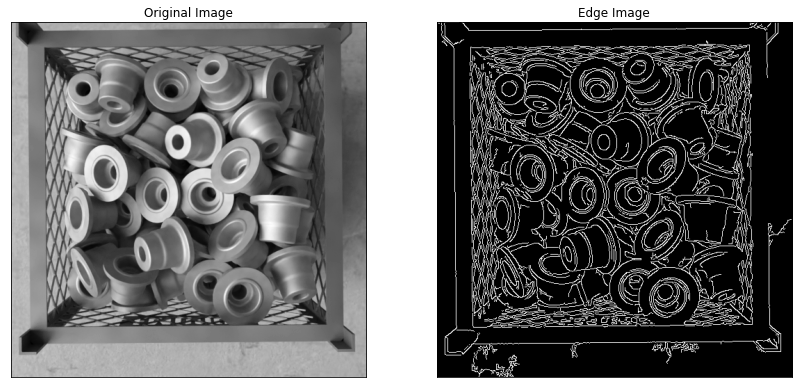

In [43]:
import cv2 as cv

img = np.array(color*255, dtype='uint8')

edg = cv.Canny(img,0,100)

plt.gcf().set_size_inches(14,8)
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(edg, cmap='gray')
plt.title('Edge Image')
plt.xticks([])
plt.yticks([])

plt.show()

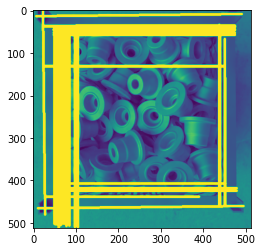

In [65]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 0.5
theta = np.pi/360
threshold = 100
min_line_length = 300
max_line_gap = 50
line_image = np.copy(img) #creating an image copy to draw lines on
# Run Hough on the edge-detected image
lines = cv.HoughLinesP(edg, rho, theta, threshold, np.array([]),
                       min_line_length, max_line_gap)
# Iterate over the output "lines" and draw lines on the image copy
for line in lines:
    for x1,y1,x2,y2 in line:
        cv.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

plt.imshow(line_image)

Skimage implementation:

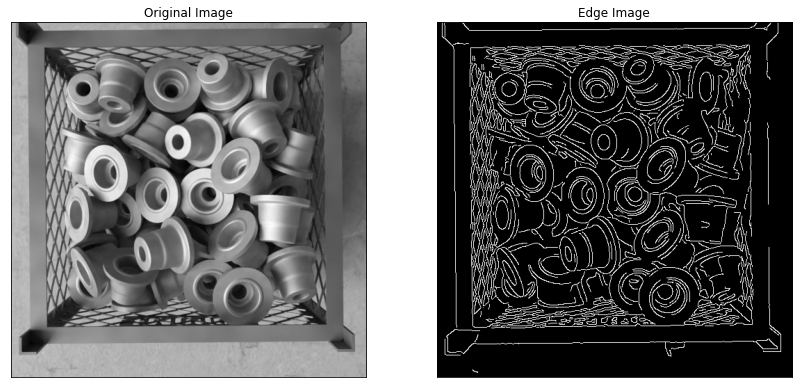

In [67]:
from skimage.feature import canny

img = np.array(color*255, dtype='uint8')

edg = canny(img, sigma=1)

plt.gcf().set_size_inches(14,8)
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(edg, cmap='gray')
plt.title('Edge Image')
plt.xticks([])
plt.yticks([])

plt.show()

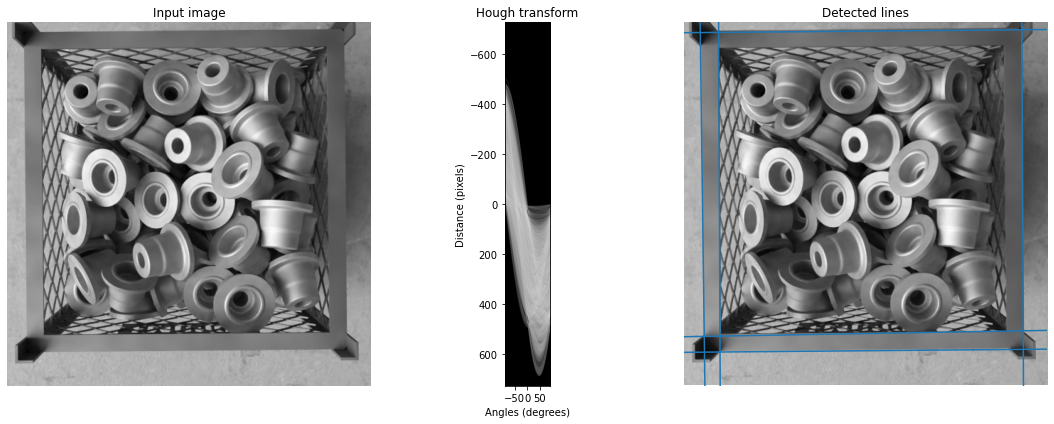

In [184]:
from skimage.transform import hough_line, hough_line_peaks
from matplotlib import cm

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi/2, np.pi/2, 360, endpoint=True)
h, theta, d = hough_line(edg, theta=tested_angles)

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(img, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(img, cmap=cm.gray)
ax[2].set_ylim((img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

accum, angles, dists = hough_line_peaks(h, theta, d)

for angle, dist in zip(angles, dists):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))
    
plt.tight_layout()
plt.show()

Looks much better.

Let's get only the vertical lines.

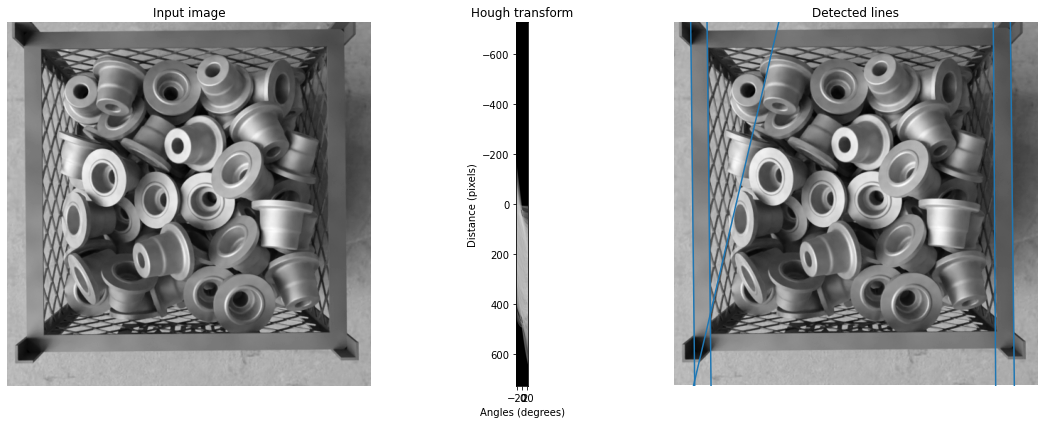

In [185]:
from skimage.transform import hough_line, hough_line_peaks
from matplotlib import cm

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi/8, np.pi/8, 180, endpoint=True)
h, theta, d = hough_line(edg, theta=tested_angles)

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(img, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(img, cmap=cm.gray)
ax[2].set_ylim((img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

accum, angles, dists = hough_line_peaks(h, theta, d)

for angle, dist in zip(angles, dists):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))
    
plt.tight_layout()
plt.show()

### Find 4 parallel lines

Based on density estimation and [this answer](https://stackoverflow.com/a/35151947).

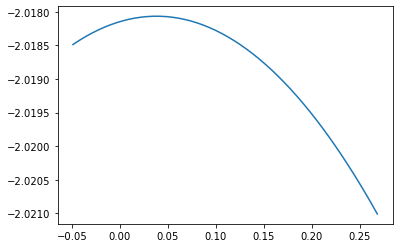

In [105]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(angles.reshape(-1,1))

s = np.linspace(min(angles)-np.mean(angles),max(angles)+np.mean(angles))
plt.plot(s, kde.score_samples(s.reshape(-1,1)))
plt.show()

Not very useful, let's try DBSCAN.

In [181]:
from sklearn.cluster import DBSCAN

labels = DBSCAN(min_samples=4, eps=0.02).fit_predict(angles.reshape(-1,1))

labels

array([ 0,  0,  0,  0, -1])

Looks good.

Now for the selection of the cluster and the best 4 lines in the best cluster.

In [182]:
clusters = {l: angles[labels == l] for l in range(max(labels)+1)}

clusters_variance = dict()
for l, cluster in clusters.items():
    clusters_variance[l] = np.sum(np.abs(cluster - np.mean(cluster)))

a = np.array(list(zip(clusters_variance.keys(),clusters_variance.values())))
best_l, _ = np.sort(a, axis=0)[0]
best_l = int(best_l)
best_angles = angles[labels == best_l]

# sort angles by distance to median (within-cluster similarity)
median_angle = np.median(best_angles)
angles_dists = np.abs(best_angles - np.median(best_angles))
best_angles = np.sort(np.stack([angles_dists,best_angles], axis=1), axis=0)[:,1]

# pick top 4
best_i = np.isin(angles, best_angles[:4])
best_angles = angles[best_i]
best_dists = dists[best_i]

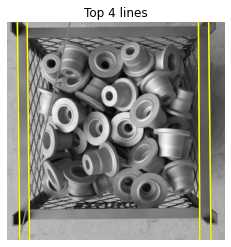

In [183]:
fig, ax = plt.subplots()

ax.imshow(img, cmap=cm.gray)
ax.set_ylim((img.shape[0], 0))
ax.set_axis_off()
ax.set_title('Top 4 lines')

for angle, dist in zip(angles, dists):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax.axline((x0, y0), slope=np.tan(angle + np.pi/2), color='gray')

for angle, dist in zip(best_angles, best_dists):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax.axline((x0, y0), slope=np.tan(angle + np.pi/2), color='yellow')

plt.show()

Now let's see if it also work for the horizontal lines.

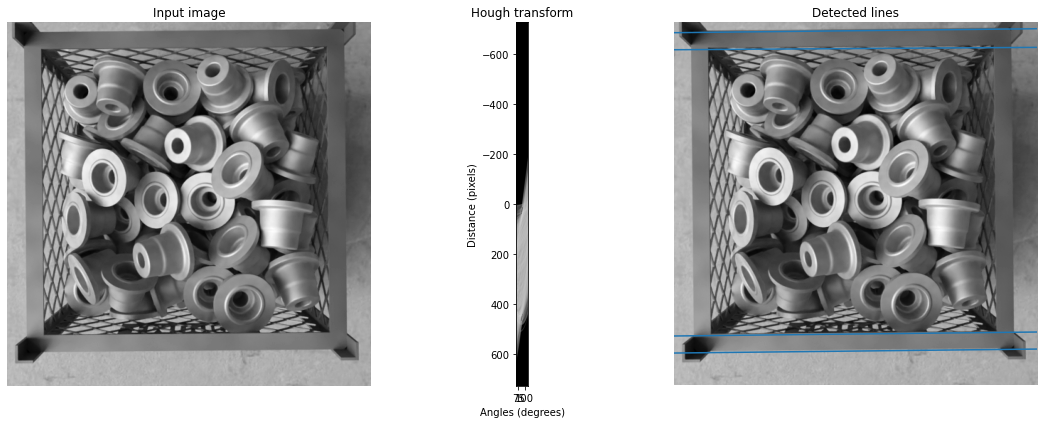

In [188]:
from skimage.transform import hough_line, hough_line_peaks
from matplotlib import cm

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(np.pi/2-np.pi/8, np.pi/2+np.pi/8, 180, endpoint=True)
h, theta, d = hough_line(edg, theta=tested_angles)

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(img, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(img, cmap=cm.gray)
ax[2].set_ylim((img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

accum, angles, dists = hough_line_peaks(h, theta, d)

for angle, dist in zip(angles, dists):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))

plt.tight_layout()
plt.show()

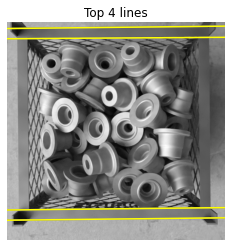

In [189]:
labels = DBSCAN(min_samples=4, eps=0.02).fit_predict(angles.reshape(-1,1))

clusters = {l: angles[labels == l] for l in range(max(labels)+1)}

clusters_variance = dict()
for l, cluster in clusters.items():
    clusters_variance[l] = np.sum(np.abs(cluster - np.mean(cluster)))

a = np.array(list(zip(clusters_variance.keys(),clusters_variance.values())))
best_l, _ = np.sort(a, axis=0)[0]
best_l = int(best_l)
best_angles = angles[labels == best_l]

# sort angles by distance to median (within-cluster similarity)
median_angle = np.median(best_angles)
angles_dists = np.abs(best_angles - np.median(best_angles))
best_angles = np.sort(np.stack([angles_dists,best_angles], axis=1), axis=0)[:,1]

# pick top 4
best_i = np.isin(angles, best_angles[:4])
best_angles = angles[best_i]
best_dists = dists[best_i]

fig, ax = plt.subplots()

ax.imshow(img, cmap=cm.gray)
ax.set_ylim((img.shape[0], 0))
ax.set_axis_off()
ax.set_title('Top 4 lines')

for angle, dist in zip(angles, dists):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax.axline((x0, y0), slope=np.tan(angle + np.pi/2), color='gray')

for angle, dist in zip(best_angles, best_dists):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax.axline((x0, y0), slope=np.tan(angle + np.pi/2), color='yellow')

plt.show()

Awesome!